<a href="https://colab.research.google.com/github/cabamarcos/P1-RRNN/blob/main/P1_RRNN_pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

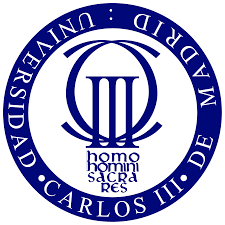

# PRÁCTICA 1: REDES DE NEURONAS
Autores: Pablo Hidalgo Delgado y Marcos Caballero Cortés   

NIAs: 100451225 y 100451247


# PREGUNTAS PROFE


1. Exactamente, el error de entrenamiento y validacion que es?? se nos pide guardar la evolucion. Vale para el error de entrenamiento ya que lo calculamos al entrenar el adaline dentro del propio modelo pero para el de validacion?? lo que hacemos es predecir con X_validation y luego calcular el error con y_validation --> solo nos sale un valor, no hay evolucion!
Sin embargo, en los de Keras, si hay evolución del error de validacion

RESPUESTA: entrenamiento y validacion --> evolucion --> pasar datos de validacion



6. Una tabla que contenga los resultados obtenidos para todos los experimentos
realizados (hiperparámetros utilizados, errores de entrenamiento, validación y
test). --> EL ERROR DE TEST SOLO SERIA PARA EL MEJOR MODELO NO? PARA EL QUE ESCOGEMOS

RESPUESTA: error de test para todos los modelos!!

EVOLUCION PARA LOS MAS SIGNIFICATIVOS / MEJOR

RESULTADOS PARA TODOS ESCOGIENDO EL MENOR ERROR

## 1. Introducción
El propósito de esta práctica es abordar un problema real de regresión utilizando dos modelos de redes de neuronas supervisados:

*   El modelo lineal Adaline.
*   El modelo no-lineal Perceptrón Multicapa.

Para ello, se nos dispone de un conjunto de datos relacionados con medidas realizadas en una turbina de gas a lo largo de 4 años. Debemos predecir el rendimiento energético de la turbina, mostrado en el campo TEY, haciendo uso del resto de mediciones de sensores.




## 2. Leer los conjuntos de datos


En primer lugar, importamos todas las librerías que se van a utilizar a lo largo de la práctica

In [1]:
import random
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import table

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model

import pickle
import seaborn as sns
import json

Leemos los conjuntos de datos, correspondientes a las medidas de 1 solo año, y los juntamos en un mismo dataframe de pandas.

In [2]:
archivos_csv = ['gt_2011.csv', 'gt_2012.csv', 'gt_2013.csv', 'gt_2014.csv', 'gt_2015.csv']

datos = pd.DataFrame()

# Concatenamos todos los archivos en un mismo dataframe
for archivo in archivos_csv:
    # Leemos el archivo
    df_temporal = pd.read_csv(archivo)
    # Concatenamos el archivo en el dataframe final
    datos = pd.concat([datos, df_temporal], ignore_index=True)

## 3. Análisis Exploratorio de Datos (EDA)
Antes de empezar con la división en datos de entrenamiento y test, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestro dataset. Esto nos servirá para comprender mejor los datos y optimizar la obtención de nuestro modelo.


### 3.1 Información básica

In [3]:
datos.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


El conjunto de datos se compone de 36733 instancias y 11 atributos de tipo float64.

También podemos observar que no existen columnas que contengan valores nulos.

### 3.2 Atributos compuestos de valores constantes

A continuación, vamos a analizar si existen columnas constantes en nuestro conjunto de datos. En ese caso, podremos eliminarlas de nuestro dataset ya que no aportan ninguna información a la variable de respuesta y no existe riesgo de information leakage.

In [4]:
# Eliminamos las columnas con solo un valor único
columnas_constantes = []
for col in datos.columns:
    if datos[col].nunique() == 1:
        print(col)
        columnas_constantes.append(col)
if len(columnas_constantes) == 0:
  print("No existen atributos con valores constantes")

No existen atributos con valores constantes


## 4. División de datos en train, validation y test.
Una vez explorado y analizado nuestro conjunto de datos, dividimos el dataset en conjuntos de entrenamiento (train), prueba (test) y validación (validation). Para ello, utilizamos la función train_test_split de la librería sklearn. Dividimos los datos en un 70% para train, un 15% para test, y un 15% para validation tal y como se nos pide en el enunciado de la práctica.

Antes de realizar la división, debemos separar la variable de respuesta del resto del conjunto de datos.

In [5]:
X = datos.drop("TEY", axis = 1)
y = datos["TEY"]

Dividimos el conjunto de datos. Lo hacemos especificando el parámetro random_state a 42 para que se aleatorizen los datos y el resultado sea reproducible.


In [6]:
# Dividimos los datos originales en conjuntos de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, shuffle = True)

# Dividimos el conjunto de prueba en conjuntos de validación (15%) y test (15%)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=40, shuffle = True)

# Guardamos los conjuntos de datos en archivos CSV
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_validation.to_csv('X_validation.csv', index=False)
y_validation.to_csv('y_validation.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

## 5. Preproceso
Previamente a entrenar los modelos, debemos realizar una transformación de los datos para que puedan ser interpretados por el algoritmo de manera eficiente. Las transformaciones de datos que realizamos son las siguientes:

### 5.1 Normalización
Para que no se produzca information leakage y no dar información al conjunto de test, normalizamos todos los datos con el mínimo y máximo obtenido del conjunto de entrenamiento.

In [7]:
for columna in X_train:
  # Obtenemos el minimo y el maximo de cada columna del conjunto de train
  min = X_train[columna].min()
  max = X_train[columna].max()
  # Conjunto de entrenamiento
  X_train[columna] = (X_train[columna] - min)/(max - min)
  # Conjunto de validación
  X_validation[columna] = (X_validation[columna] - min)/(max - min)
  # Conjunto de test
  X_test[columna] = (X_test[columna] - min)/(max - min)

y_min = y_train.min()
y_max = y_train.max()
# Conjunto de entrenamiento
y_train = (y_train - y_min)/(y_max - y_min)
# Conjunto de validación
y_validation = (y_validation - y_min)/(y_max - y_min)
# Conjunto de test
y_test = (y_test - y_min)/(y_max - y_min)

### 5.2 Aleatorización
La aleatorización de los datos la hemos realizado al dividir el conjunto de datos en train, test y validation al especificar el parametro shuffle = True

## 6. Modelo lineal Adaline

### 6.0 Nested loops

In [28]:
class Adaline_for:
    def __init__(self, learning_rate=0.1, epochs=50, random_seed = 45):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.random_seed = random_seed
        self.error_entrenamiento = []
        self.error_validation = []
        self.historical_weights = []
        self.best_epoch = {
                          'MSE Validation': 100000000, # Para que al comparar el error de valdiación en la primera iteración siempre sea menor
                          'Best Epoch': 0
                          }

    def fit(self, X, y, X_validation, y_validation):
      # Inicializamos el Adaline
        self.__initialize_Adaline(X)

        # Convertimos X e y a dos arrays de numpy
        X = X.values
        y = y.to_numpy().reshape(-1, 1)

        X_validation = X_validation.values
        y_validation = y_validation.to_numpy().reshape(-1, 1)

        # Para cada época
        for i in range(self.epochs):
          error_filas = []
          error_filas_validation = []
          # Para cada fila
          for fila in range(X.shape[0]):
            # Calculamos la salida
            salida = self.weights * X[fila]
            salida = salida.sum() + self.bias
            # Obtenemos el error
            error = y[fila] - salida
            error_filas.append(error**2) # Insertamos el error al cuadrado de cada fila para luego obtener el MSE de entrenamiento
            # Actualizamos los pesos
            self.weights += self.learning_rate * error * X[fila]
            # Actualizamos el umbral
            self.bias += self.learning_rate * error

          # Obtenemos el MSE y lo insertamos en la lista del error de entrenamiento
          self.error_entrenamiento.append(np.array(error_filas).mean())

          for fila in range(X_validation.shape[0]):
            # Calculamos la salida
            salida_validation = self.weights * X_validation[fila]
            salida_validation = salida_validation.sum() + self.bias
            # Obtenemos el error
            error_validation_fila = y_validation[fila] - salida_validation
            error_filas_validation.append(error_validation_fila**2) # Insertamos el error al cuadrado de cada fila para luego obtener el MSE de entrenamiento


          error_validation = np.array(error_filas_validation).mean() # Obtenemos la media de los errores de validación
          # Guardamos la época con el menor valor de validación
          if error_validation < self.best_epoch['MSE Validation']:
            self.best_epoch['MSE Validation'] = error_validation
            self.best_epoch['Best Epoch'] = i + 1
          self.error_validation.append(error_validation)

    def predict(self, X):
      X = X.values
      # Calculamos la salida para cada muestra en X
      predictions = []
      for fila in range(X.shape[0]):
         salida = self.weights * X[fila]
         salida = salida.sum() + self.bias
         predictions.append(salida)  # Agrega la salida a la lista de predicciones
      return np.array(predictions)


    def __initialize_Adaline(self,X):
        np.random.seed(self.random_seed)
        n_samples, n_features = X.shape
        self.weights = np.random.uniform(-1,1,size = n_features)
        self.bias = np.random.uniform(-1,1)

(LR=0.4, Épocas=10) --> Tiempo de entrenamiento 5.90 s , Best Epoch: {'MSE Validation': 0.000277758825796987, 'Best Epoch': 10} MSE validación: [0.0003605909762512799, 0.0002835348543734454, 0.0002782376472584099, 0.0002777991663590752, 0.00027776222915366395, 0.0002777591129445296, 0.0002777588500121915, 0.00027775882782685743, 0.0002777588259549339, 0.000277758825796987], MSE entrenamiento: [0.003631254307459944, 0.0012669743107493988, 0.0012647012799105245, 0.001264731133403781, 0.0012647352313513065, 0.0012647355883644857, 0.0012647356185681098, 0.0012647356211171613, 0.0012647356213322455, 0.0012647356213503936], MSE test: 0.00028056215004674
(LR=0.4, Épocas=20) --> Tiempo de entrenamiento 8.10 s , Best Epoch: {'MSE Validation': 0.0002777588257824313, 'Best Epoch': 18} MSE validación: [0.0003605909762512799, 0.0002835348543734454, 0.0002782376472584099, 0.0002777991663590752, 0.00027776222915366395, 0.0002777591129445296, 0.0002777588500121915, 0.00027775882782685743, 0.0002777588

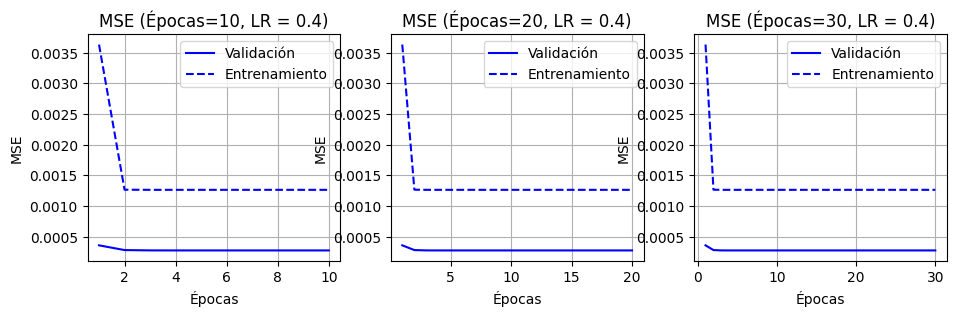

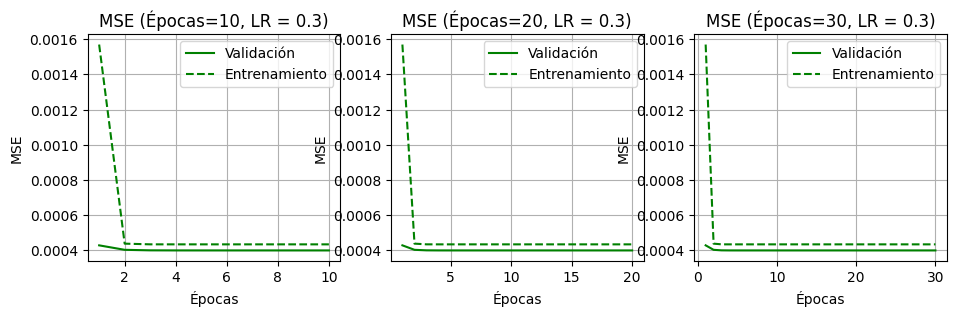

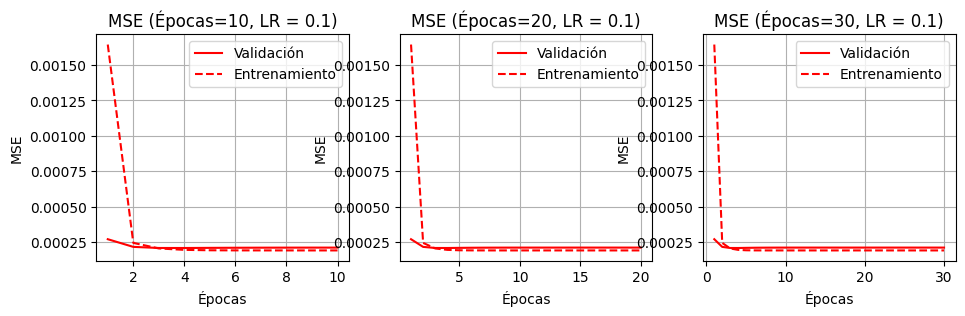

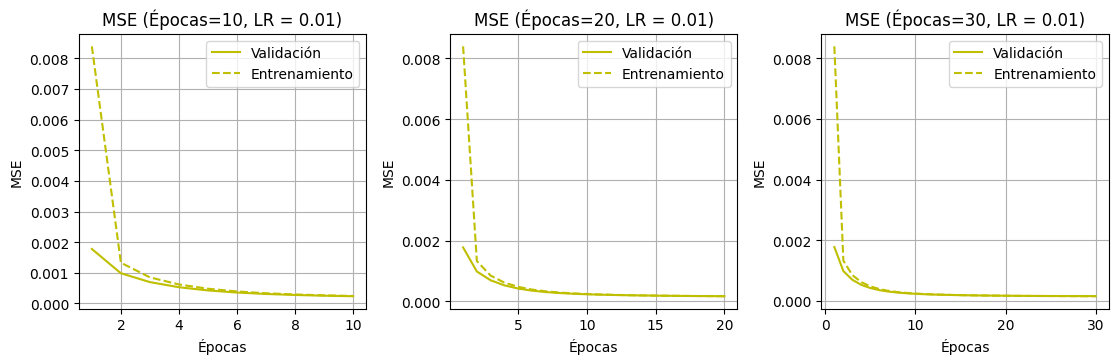

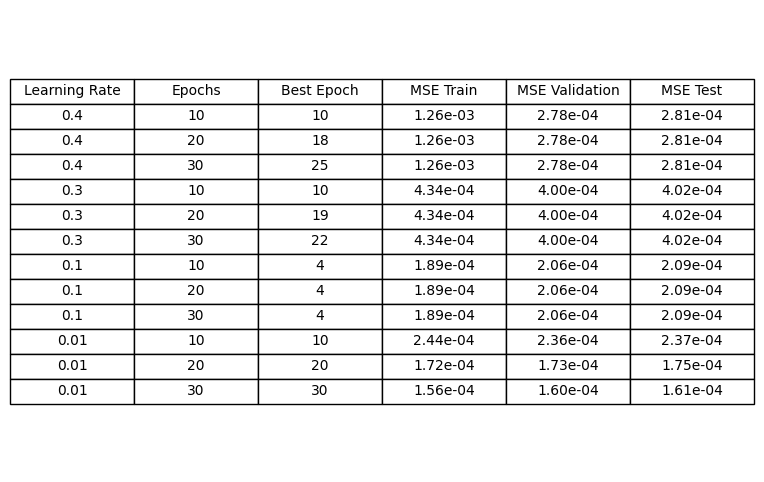

In [29]:
# Lista de tasas de aprendizaje a probar
learning_rates = [0.4,0.3,0.1, 0.01]
# Lista de epochs a probar
epochs_values = [10,20,30]

# Crear un diccionario para almacenar los resultados
results = {
    'Learning Rate': [],
    'Epochs': [],
    'Best Epoch': [],
    'MSE Train': [],
    'MSE Validation': [],
    'MSE Test' : []
}

# Lista para almacenar los errores MSE de validación
mse_validation_values = []
mse_train_values = []
tiempo_entrenamiento = []

for lr in learning_rates:
    mse_train_values_lr = []
    mse_lr_values = []  # Almacenamos los errores para cada tasa de aprendizaje
    tiempo_lr_values = []  # Almacenamos los tiempos para cada tasa de aprendizaje


    for epochs in epochs_values:
        # Creamos el modelo
        modelo = Adaline_for(learning_rate=lr, epochs=epochs)
        # Entrenamos el modelo y obtenemos el tiempo que ha tardado en entrenarse
        start_time = time.time()
        modelo.fit(X_train, y_train, X_validation, y_validation)
        tiempo_total = time.time() - start_time
        tiempo_lr_values.append(tiempo_total) # Guardamos el tiempo

        # Obtenemos el MSE de train y validation y lo guardamos
        mse_validation = modelo.error_validation
        mse_lr_values.append(mse_validation)
        mse_train = modelo.error_entrenamiento
        mse_train_values_lr.append(mse_train)

        # Predecimos los datos de test
        prediccion = modelo.predict(X_test)
        # Obtenemos el MSE de test
        mse_test = mean_squared_error(prediccion, y_test)

        print(f'(LR={lr}, Épocas={epochs}) --> Tiempo de entrenamiento {tiempo_total:.2f} s , Best Epoch: {modelo.best_epoch} MSE validación: {mse_validation}, MSE entrenamiento: {mse_train}, MSE test: {mse_test}')

        # Almacenamos los resultados en el diccionario
        results['Learning Rate'].append(lr)
        results['Epochs'].append(epochs)
        results['MSE Train'].append(np.min(mse_train))
        results['MSE Validation'].append(np.min(mse_validation))
        results['MSE Test'].append(mse_test)
        results['Best Epoch'].append(modelo.best_epoch['Best Epoch'])

    print("\n")
    mse_validation_values.append(mse_lr_values)
    mse_train_values.append(mse_train_values_lr)
    tiempo_entrenamiento.append(tiempo_lr_values)


# CREAMOS LAS GRÁFICAS
# Define colores para los gráficos
colores = ['b', 'g', 'r', 'y']
# Etiquetas para los errores de validación y entrenamiento
etiquetas = ['Validación', 'Entrenamiento']

# Iteramos a través de las tasas de aprendizaje
for i, lr in enumerate(learning_rates):
    plt.figure(figsize=(15, 10))

    # Iteramos a través de los valores de épocas
    for j, epochs in enumerate(epochs_values):
        # Configuramos un subplot para el gráfico
        plt.subplot(3, 4, j + 1)

        # Obtenemos los valores de MSE de validación y entrenamiento para la tasa de aprendizaje y épocas actuales
        mse_values_validation = mse_validation_values[i][j]
        mse_values_train = mse_train_values[i][j]

        # Creamos el gráfico para el error de validación
        plt.plot(range(1, len(mse_values_validation) + 1), mse_values_validation, color=colores[i], label=f'LR={lr} (Val)')

        # Creamos el gráfico para el error de entrenamiento
        plt.plot(range(1, len(mse_values_train) + 1), mse_values_train, linestyle='--', color=colores[i], label=f'LR={lr} (Train)')

        # Configuramos las etiquetas y título del gráfico
        plt.xlabel('Épocas')
        plt.ylabel('MSE')
        plt.title(f'MSE (Épocas={epochs}, LR = {lr})')
        plt.grid(True)
        plt.legend(etiquetas)

plt.tight_layout()
plt.show()


# PRINTEAMOS LA TABLA
# Creamos un DataFrame a partir del diccionario de resultados
results_df = pd.DataFrame(results)

# Seleccionamos las dos últimas columnas y aplicamos formato en notación científica
results_df[['MSE Train', 'MSE Validation', 'MSE Test']] = results_df[['MSE Train', 'MSE Validation', 'MSE Test']].applymap(lambda x: f'{x:.2e}')

# Creamos una figura
fig, ax = plt.subplots(figsize=(8, 6))

# Creamos los datos de la tabla
data = [['Learning Rate', 'Epochs', 'Best Epoch', 'MSE Train', 'MSE Validation', 'MSE Test']]
data += list(map(list, results_df.values))

# Creamos la tabla en la figura
tab = table(ax, cellText=data, loc='center', cellLoc='center', cellColours=[['#ffffff'] * 6] * (len(data)), colWidths=[0.2] * 6)
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(1, 1.5)

# Ocultamos ejes
ax.axis('off')

# Mostramos la figura
plt.show()

In [30]:
# Creamos el mejor modelo
mejor_modelo = Adaline_for(learning_rate=0.1, epochs=4)
# Entrenamos de nuevo el modelo
mejor_modelo.fit(X_train, y_train, X_validation, y_validation)

# Guardamos el mejor modelo en un archivo pickle
with open("mejor_modelo_Adaline_for.pkl", "wb") as modelo_file:
    pickle.dump(mejor_modelo, modelo_file)

# Obtenemos el MSE de entrenamiento y validación y los guardamos
mse_validation = mejor_modelo.error_validation
error_entrenamiento = mejor_modelo.error_entrenamiento

# Guardamos los errores de validación y entrenamiento en un archivo CSV
errores_df = pd.DataFrame({'Entrenamiento': error_entrenamiento, 'Validacion': mse_validation})
errores_df.to_csv('errores_Adaline_for.csv', index=False)

MSE de test Adaline: 2.075e-04
MSE de test desnormalizado Adaline: 1.2717251432497718


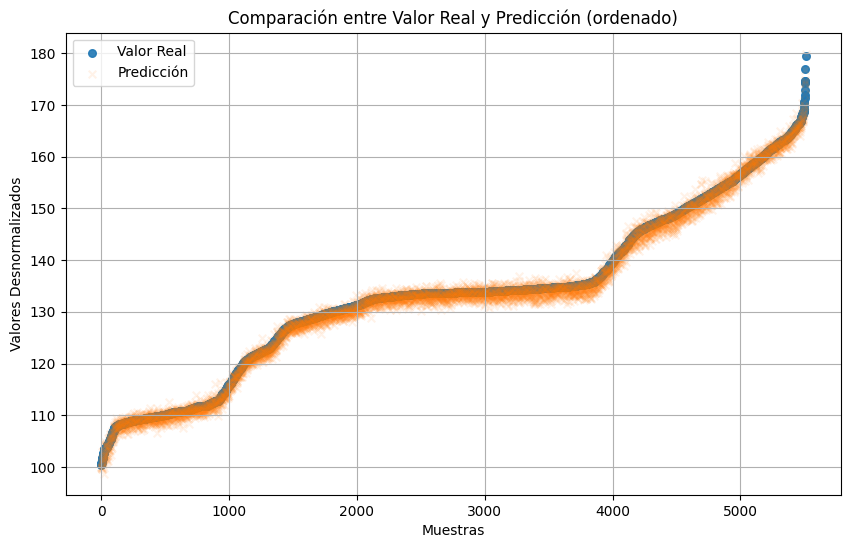

In [31]:
# Cargamos el mejor modelo Adaline
with open("mejor_modelo_Adaline_for.pkl", "rb") as modelo_file:
    mejor_modelo_adaline = pickle.load(modelo_file)

# Predecimos sobre los datos de test
prediccion = mejor_modelo_adaline.predict(X_test)
# Obtenemos el MSE
mse_test = mean_squared_error(prediccion, y_test)
print(f"MSE de test Adaline: {mse_test:.3e}")

# Desnormalizamos las predicciones y las salidas deseadas
prediccion_desnormalizada = prediccion * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min
# Obtenemos el MSE en la escala original de los datos
mse_test_desnormalizado = mean_squared_error(prediccion_desnormalizada, y_test_desnormalizada)
print(f"MSE de test desnormalizado Adaline: {mse_test_desnormalizado}")

# Creamos un DataFrame con las predicciones y los valores reales
data_to_save = pd.DataFrame({'Prediccion': prediccion_desnormalizada.flatten(), 'Valor Real': y_test_desnormalizada})
# Ordenamos los valores reales de menor a mayor
sorted_data = data_to_save.sort_values(by='Valor Real')
# Guardamos el DataFrame en un archivo CSV
sorted_data.to_csv('predicciones_y_deseados_Adaline_for.csv', index=False)
# Convertimos las columnas en listas de números
predicciones = sorted_data['Prediccion'].tolist()
valores_reales = sorted_data['Valor Real'].tolist()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(range(len(valores_reales)), valores_reales, label='Valor Real', marker='o', s=30, alpha=0.9)
plt.scatter(range(len(predicciones)), predicciones, label='Predicción', marker='x', s=30, alpha=0.095)
plt.xlabel('Muestras')
plt.ylabel('Valores Desnormalizados')
plt.title('Comparación entre Valor Real y Predicción (ordenado)')
plt.legend()
plt.grid(True)

# Mostramos la gráfica
plt.show()

### 6.1 Implementación



In [12]:
class Adaline:
    def __init__(self, learning_rate=0.1, epochs=100, random_seed = 42):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.umbral = None
        self.random_seed = random_seed
        self.error_entrenamiento = []
        self.error_validation = []
        self.best_epoch = {
                          'MSE Validation': 100000000, # Para que al comparar el error de valdiación en la primera iteración siempre sea menor
                          'Best Epoch': 0
                          }

    def __initialize_Adaline(self,X):
        np.random.seed(self.random_seed)
        n_samples, n_features = X.shape
        self.weights = np.random.uniform(-1, 1, size=(n_features, 1))
        self.umbral = np.random.uniform(-1,1)

    def fit(self, X, y, X_validation, y_validation):
        # Inicializamos el Adaline
        self.__initialize_Adaline(X)
        # Convertimos X e y a dos arrays de numpy
        X = X.values
        y = y.to_numpy().reshape(-1, 1)

        X_validation = X_validation.values
        y_validation = y_validation.to_numpy().reshape(-1, 1)

        for i in range(self.epochs):
          # Obtenemos la salida
          salida = np.dot(X, self.weights) + self.umbral

          # Obtenemos los errores
          errores = y - salida

          # Actualizamos el vector de pesos
          new_weights = self.learning_rate * X * errores # Calculamos los nuevos pesos para cada entrada
          media_new_weights = np.mean(new_weights, axis=0) # Calculamos la media de los nuevos pesos
          self.weights += media_new_weights.reshape(-1, 1)

          # Actualizamos el umbral
          self.umbral += self.learning_rate * errores.mean()

          # Obtenemos y guardamos el MSE
          error_entrenamiento = mean_squared_error(salida, y)
          self.error_entrenamiento.append(error_entrenamiento)

          # Obtenemos la salida para los datos de validación
          salida_validation = np.dot(X_validation, self.weights) + self.umbral
          # Obtenemos el error de validación (MSE)
          error_validation = mean_squared_error(salida_validation, y_validation)
          self.error_validation.append(error_validation)

          # Guardamos la época con el menor valor de validación
          if error_validation < self.best_epoch['MSE Validation']:
            self.best_epoch['MSE Validation'] = error_validation
            self.best_epoch['Best Epoch'] = i + 1

    def predict(self, X):
      # Convertimos X a un array de numpy
      X = X.values
      salida = np.dot(X, self.weights) + self.umbral
      return salida



### 6.2 Experimentos realizados
A continuación, debemos elegir los mejores hiperparámetros para nuestro conjunto de datos. Para ello, construimos distintos modelos con diferentes hiperparámetros. Escogeremos el modelo con la combinación de hiperparámetros cuyo MSE de validación sea el menor.

(LR=0.5, Épocas=50) --> Tiempo de entrenamiento 0.11 s , Best Epoch: {'MSE Validation': 3.496589939410964, 'Best Epoch': 1} MSE validación: [3.496589939410964, 3.938794238821441, 4.452690572668385, 5.02092498712306, 5.681603358280843, 6.4114823267996615, 7.25975744918256, 8.197020578876643, 9.285221652024974, 10.488584375468301, 11.883790198543732, 13.428600756928592, 15.216788391653733, 17.19971819540839, 19.49108240016677, 22.0361409513578, 24.971914225172398, 28.238161986194903, 31.99935813873648, 36.190796099727834, 41.00941957632692, 46.387669347014075, 52.56108548794615, 59.46164689883051, 67.37100438886354, 76.22409957527965, 86.35794770714097, 97.71524524080844, 110.69981086964337, 125.26868835288333, 141.90669055054613, 160.5941618348506, 181.91457189375262, 205.88360474727364, 233.205438192625, 263.94715702515646, 298.9612547978324, 338.3875086543966, 383.2613806309235, 433.82342023540866, 491.3356549944357, 556.176282557806, 629.8888615484213, 713.0374938562168, 807.51669967

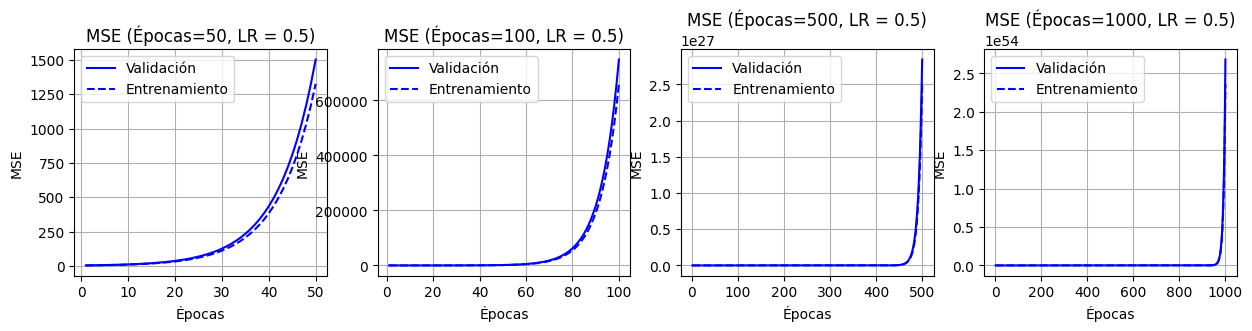

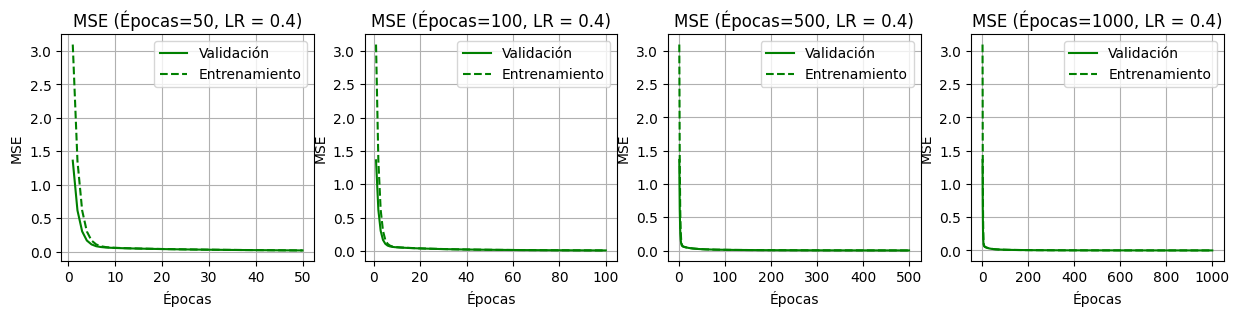

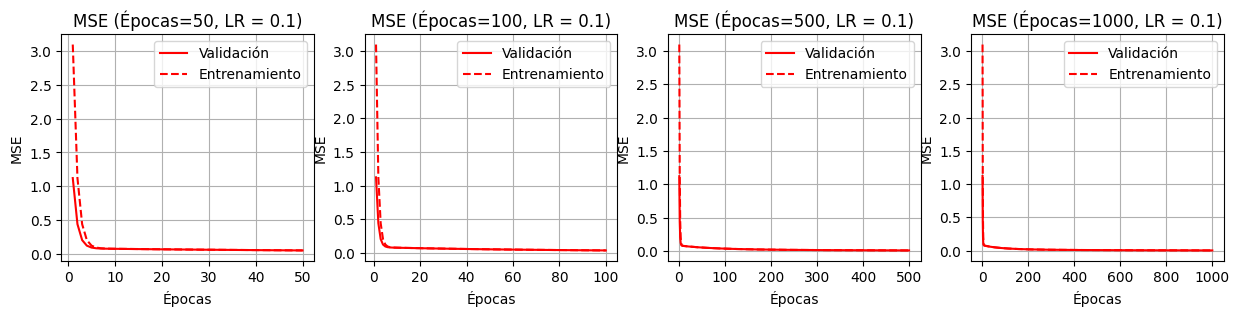

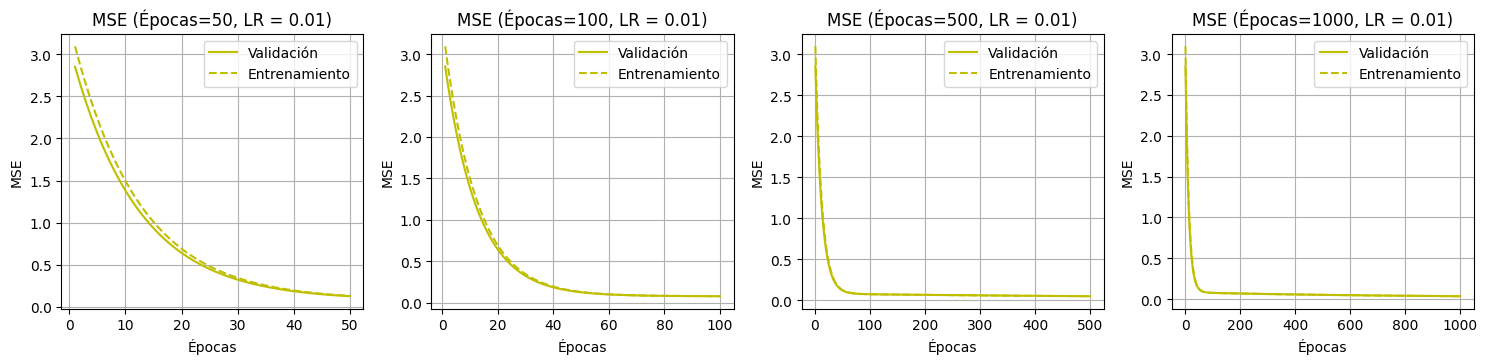

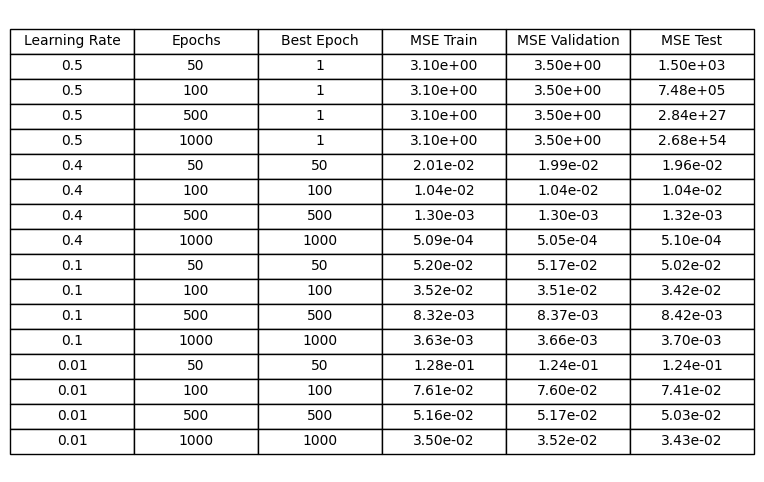

In [13]:
# Lista de tasas de aprendizaje a probar
learning_rates = [0.5, 0.4, 0.1, 0.01]
# Lista de epochs a probar
epochs_values = [50, 100, 500, 1000]

# Crear un diccionario para almacenar los resultados
results = {
    'Learning Rate': [],
    'Epochs': [],
    'Best Epoch': [],
    'MSE Train': [],
    'MSE Validation': [],
    'MSE Test' : []
}

# Lista para almacenar los errores MSE de validación
mse_validation_values = []
mse_train_values = []
tiempo_entrenamiento = []

for lr in learning_rates:
    mse_train_values_lr = []
    mse_lr_values = []  # Almacenamos los errores para cada tasa de aprendizaje
    tiempo_lr_values = []  # Almacenamos los tiempos para cada tasa de aprendizaje


    for epochs in epochs_values:
        # Creamos el modelo
        modelo = Adaline(learning_rate=lr, epochs=epochs)
        # Entrenamos el modelo y obtenemos el tiempo que ha tardado en entrenarse
        start_time = time.time()
        modelo.fit(X_train, y_train, X_validation, y_validation)
        tiempo_total = time.time() - start_time
        tiempo_lr_values.append(tiempo_total) # Guardamos el tiempo

        # Obtenemos el MSE de train y validation y lo guardamos
        mse_validation = modelo.error_validation
        mse_lr_values.append(mse_validation)
        mse_train = modelo.error_entrenamiento
        mse_train_values_lr.append(mse_train)

        # Predecimos los datos de test
        prediccion = modelo.predict(X_test)
        # Obtenemos el MSE de test
        mse_test = mean_squared_error(prediccion, y_test)

        print(f'(LR={lr}, Épocas={epochs}) --> Tiempo de entrenamiento {tiempo_total:.2f} s , Best Epoch: {modelo.best_epoch} MSE validación: {mse_validation}, MSE entrenamiento: {mse_train}, MSE test: {mse_test}')

        # Almacenamos los resultados en el diccionario
        results['Learning Rate'].append(lr)
        results['Epochs'].append(epochs)
        results['MSE Train'].append(np.min(mse_train))
        results['MSE Validation'].append(np.min(mse_validation))
        results['MSE Test'].append(mse_test)
        results['Best Epoch'].append(modelo.best_epoch['Best Epoch'])

    print("\n")
    mse_validation_values.append(mse_lr_values)
    mse_train_values.append(mse_train_values_lr)
    tiempo_entrenamiento.append(tiempo_lr_values)


# CREAMOS LAS GRÁFICAS
# Define colores para los gráficos
colores = ['b', 'g', 'r', 'y']
# Etiquetas para los errores de validación y entrenamiento
etiquetas = ['Validación', 'Entrenamiento']

# Iteramos a través de las tasas de aprendizaje
for i, lr in enumerate(learning_rates):
    plt.figure(figsize=(15, 10))

    # Iteramos a través de los valores de épocas
    for j, epochs in enumerate(epochs_values):
        # Configuramos un subplot para el gráfico
        plt.subplot(3, 4, j + 1)

        # Obtenemos los valores de MSE de validación y entrenamiento para la tasa de aprendizaje y épocas actuales
        mse_values_validation = mse_validation_values[i][j]
        mse_values_train = mse_train_values[i][j]

        # Creamos el gráfico para el error de validación
        plt.plot(range(1, len(mse_values_validation) + 1), mse_values_validation, color=colores[i], label=f'LR={lr} (Val)')

        # Creamos el gráfico para el error de entrenamiento
        plt.plot(range(1, len(mse_values_train) + 1), mse_values_train, linestyle='--', color=colores[i], label=f'LR={lr} (Train)')

        # Configuramos las etiquetas y título del gráfico
        plt.xlabel('Épocas')
        plt.ylabel('MSE')
        plt.title(f'MSE (Épocas={epochs}, LR = {lr})')
        plt.grid(True)
        plt.legend(etiquetas)

plt.tight_layout()
plt.show()


# PRINTEAMOS LA TABLA
# Creamos un DataFrame a partir del diccionario de resultados
results_df = pd.DataFrame(results)

# Seleccionamos las dos últimas columnas y aplicamos formato en notación científica
results_df[['MSE Train', 'MSE Validation', 'MSE Test']] = results_df[['MSE Train', 'MSE Validation', 'MSE Test']].applymap(lambda x: f'{x:.2e}')

# Creamos una figura
fig, ax = plt.subplots(figsize=(8, 6))

# Creamos los datos de la tabla
data = [['Learning Rate', 'Epochs', 'Best Epoch', 'MSE Train', 'MSE Validation', 'MSE Test']]
data += list(map(list, results_df.values))

# Creamos la tabla en la figura
tab = table(ax, cellText=data, loc='center', cellLoc='center', cellColours=[['#ffffff'] * 6] * (len(data)), colWidths=[0.2] * 6)
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(1, 1.5)

# Ocultamos ejes
ax.axis('off')

# Mostramos la figura
plt.show()

### 6.3 Elección del mejor modelo
Los hiperparámetros que minimizan el error de validación se corresponden con una tasa de aprendizaje de 0.4 y 500 épocas. Guardamos en un fichero el mejor modelo, así como la evolución del error de entrenamiento y de validación del mismo.

In [18]:
# Creamos el mejor modelo
mejor_modelo = Adaline(learning_rate=0.4, epochs=1000)
# Entrenamos de nuevo el modelo
mejor_modelo.fit(X_train, y_train, X_validation, y_validation)

# Guardamos el mejor modelo en un archivo pickle
with open("mejor_modelo_Adaline.pkl", "wb") as modelo_file:
    pickle.dump(mejor_modelo, modelo_file)

# Obtenemos el MSE de entrenamiento y validación y los guardamos
mse_validation = mejor_modelo.error_validation
error_entrenamiento = mejor_modelo.error_entrenamiento

# Guardamos los errores de validación y entrenamiento en un archivo CSV
errores_df = pd.DataFrame({'Entrenamiento': error_entrenamiento, 'Validacion': mse_validation})
errores_df.to_csv('errores_Adaline.csv', index=False)

### 6.4 Error de test y predicciones
Obtenemos el mejor modelo escogido en el apartado anterior. Realizamos las predicciones sobre los datos de test (X_test) y las evaluamos con la variable de respuesta de test (y_test).

MSE de test Adaline: 5.102e-04
MSE de test desnormalizado Adaline: 3.1271966527144537


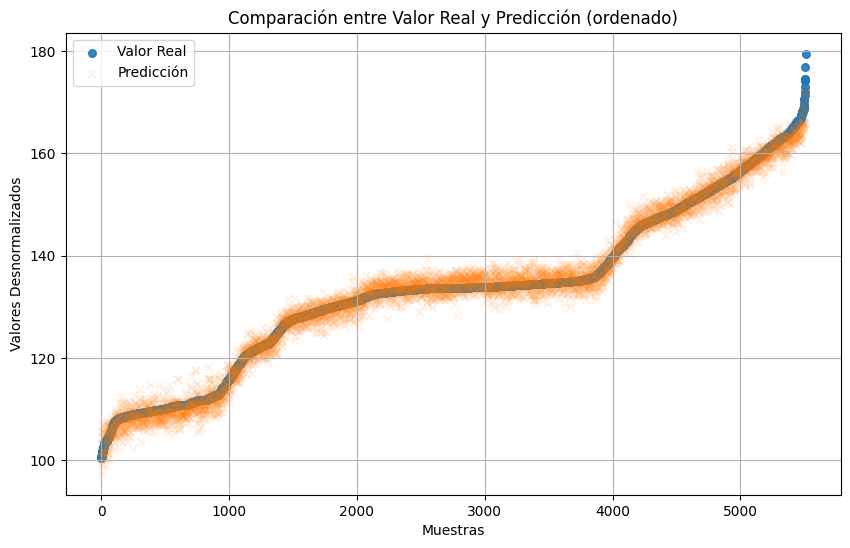

In [19]:
# Cargamos el mejor modelo Adaline
with open("mejor_modelo_Adaline.pkl", "rb") as modelo_file:
    mejor_modelo_adaline = pickle.load(modelo_file)

# Predecimos sobre los datos de test
prediccion = mejor_modelo_adaline.predict(X_test)
# Obtenemos el MSE
mse_test = mean_squared_error(prediccion, y_test)
print(f"MSE de test Adaline: {mse_test:.3e}")

# Desnormalizamos las predicciones y las salidas deseadas
prediccion_desnormalizada = prediccion * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min
# Obtenemos el MSE en la escala original de los datos
mse_test_desnormalizado = mean_squared_error(prediccion_desnormalizada, y_test_desnormalizada)
print(f"MSE de test desnormalizado Adaline: {mse_test_desnormalizado}")

# Creamos un DataFrame con las predicciones y los valores reales
data_to_save = pd.DataFrame({'Prediccion': prediccion_desnormalizada.flatten(), 'Valor Real': y_test_desnormalizada})
# Ordenamos los valores reales de menor a mayor
sorted_data = data_to_save.sort_values(by='Valor Real')
# Guardamos el DataFrame en un archivo CSV
sorted_data.to_csv('predicciones_y_deseados_Adaline.csv', index=False)
# Convertimos las columnas en listas de números
predicciones = sorted_data['Prediccion'].tolist()
valores_reales = sorted_data['Valor Real'].tolist()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(range(len(valores_reales)), valores_reales, label='Valor Real', marker='o', s=30, alpha=0.9)
plt.scatter(range(len(predicciones)), predicciones, label='Predicción', marker='x', s=30, alpha=0.095)
plt.xlabel('Muestras')
plt.ylabel('Valores Desnormalizados')
plt.title('Comparación entre Valor Real y Predicción (ordenado)')
plt.legend()
plt.grid(True)

# Mostramos la gráfica
plt.show()

### 6.5 Adaline con Keras
Comprobamos si los resultados son similares a nuestro modelo.

In [20]:
# Función para crear un modelo lineal
def create_linear():
    model = Sequential()
    model.add(Dense(1, input_shape=input_shape, activation='linear'))
    return model

Epoch 1/10
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/10
804/804 [==============================] - 2s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/10
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/10
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/10
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/10
804/804 [==============================] - 2s 3ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/10
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/10
804/804 [==============================] - 2s 2ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/10
804/804 [====================

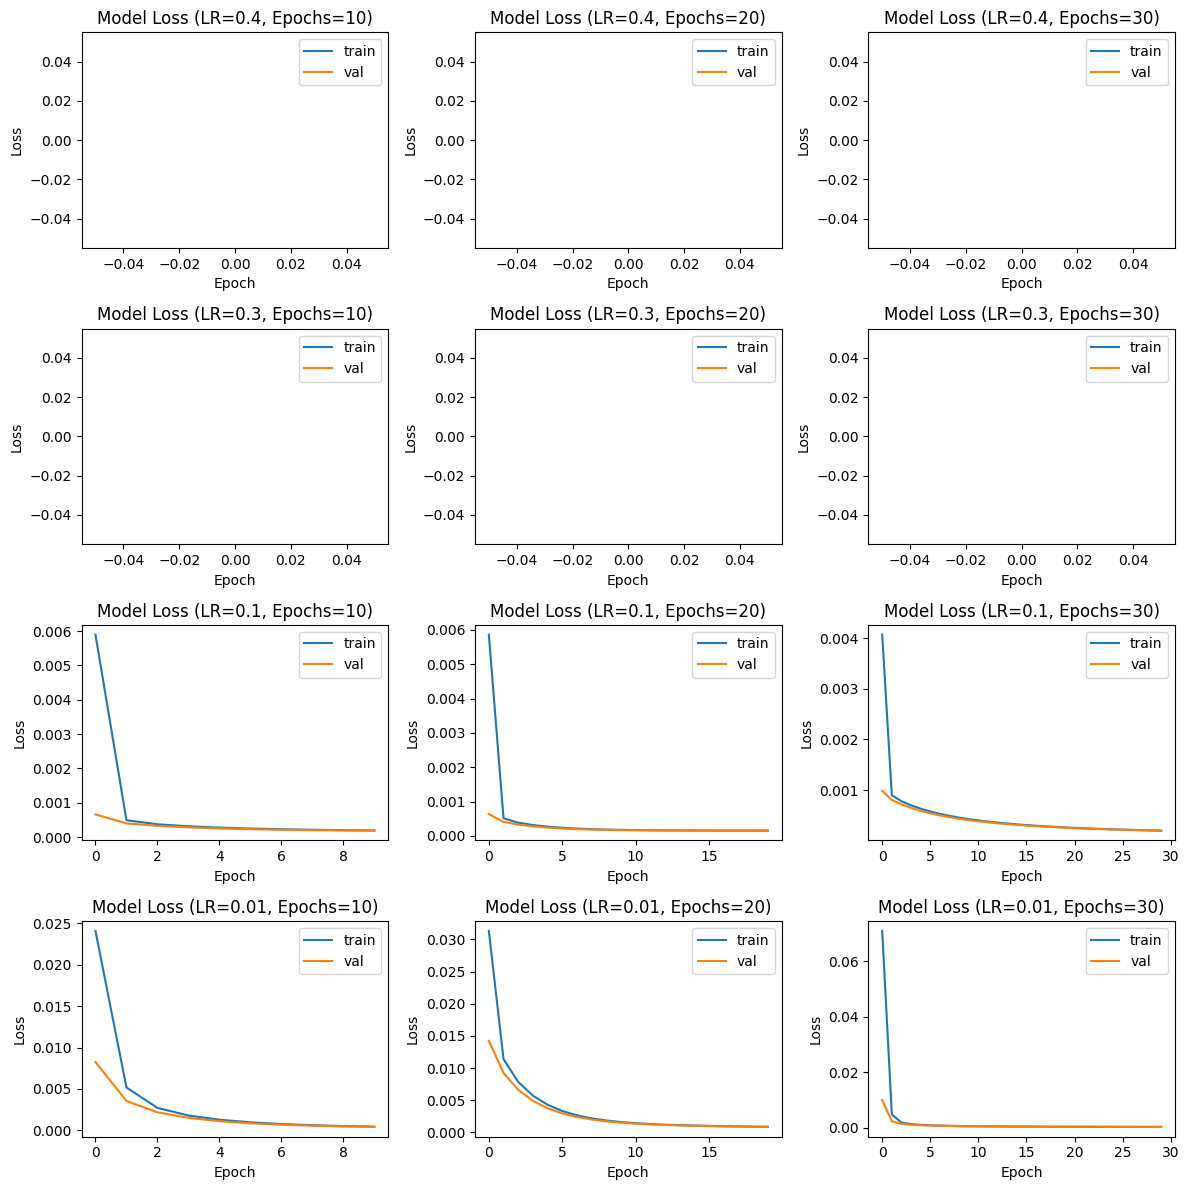

In [27]:
# Lista de tasas de aprendizaje a probar
learning_rates = [0.4,0.3,0.1,0.01]
# Lista de números de épocas a probar
epochs_values = [10,20,30]
# Definimos la forma de entrada (input_shape)
input_shape = (X_train.shape[1],)


# Configuramos el diseño de la figura para todas las gráficas
num_lr = len(learning_rates)
num_epochs = len(epochs_values)

# Creamos un grid de subplots
fig, axes = plt.subplots(num_lr, num_epochs, figsize=(12, 12))

# Entrenamos diferentes modelos para cada tasa de aprendizaje y número de épocas
for i, lr in enumerate(learning_rates):
    for j, epochs in enumerate(epochs_values):
        # Creamos un nuevo modelo
        model_adaline = create_linear()

        # Configuramos el modelo y entrenamiento con la tasa de aprendizaje y épocas actuales
        batch_size = 32
        model_adaline.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])
        start_time = time.time()
        historico = model_adaline.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation, y_validation), shuffle=False, validation_freq=1)
        tiempo_total = time.time() - start_time
        print(f"Tiempo de entrenamiento para (lr = {lr}, epoch = {epochs}): {tiempo_total}s")
        # Calculamos el MSE
        mse = historico.history['val_mse']
        # Encuentra la época en la que el MSE de validación es el menor
        best_epoch = np.argmin(mse)

        # Obtén el valor mínimo del MSE de validación
        min_mse_val = np.min(mse)

        print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Suma 1 porque las épocas comienzan desde 0
        print(f"MSE de validación mínimo: {min_mse_val:.2e}")
        # Agregarmos la gráfica de la pérdida en el subplot correspondiente
        ax = axes[i, j]
        ax.plot(historico.history['loss'], label='train')
        ax.plot(historico.history['val_loss'], label='val')
        ax.set_title(f'Model Loss (LR={lr}, Epochs={epochs})')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(loc='upper right')

# Ajustamos espaciado y mostrar la figura con todas las gráficas
plt.tight_layout()
plt.show()

Epoch 1/20
804/804 [==============================] - 4s 4ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 5.5391e-04 - val_mse: 5.5391e-04
Epoch 2/20
804/804 [==============================] - 2s 2ms/step - loss: 3.7631e-04 - mse: 3.7631e-04 - val_loss: 3.0908e-04 - val_mse: 3.0908e-04
Epoch 3/20
804/804 [==============================] - 3s 3ms/step - loss: 2.7216e-04 - mse: 2.7216e-04 - val_loss: 2.6676e-04 - val_mse: 2.6676e-04
Epoch 4/20
804/804 [==============================] - 4s 4ms/step - loss: 2.3831e-04 - mse: 2.3831e-04 - val_loss: 2.3848e-04 - val_mse: 2.3848e-04
Epoch 5/20
804/804 [==============================] - 2s 3ms/step - loss: 2.1547e-04 - mse: 2.1547e-04 - val_loss: 2.1811e-04 - val_mse: 2.1811e-04
Epoch 6/20
804/804 [==============================] - 2s 2ms/step - loss: 1.9909e-04 - mse: 1.9909e-04 - val_loss: 2.0328e-04 - val_mse: 2.0328e-04
Epoch 7/20
804/804 [==============================] - 2s 2ms/step - loss: 1.8716e-04 - mse: 1.8716e-04 - val_loss: 1.923

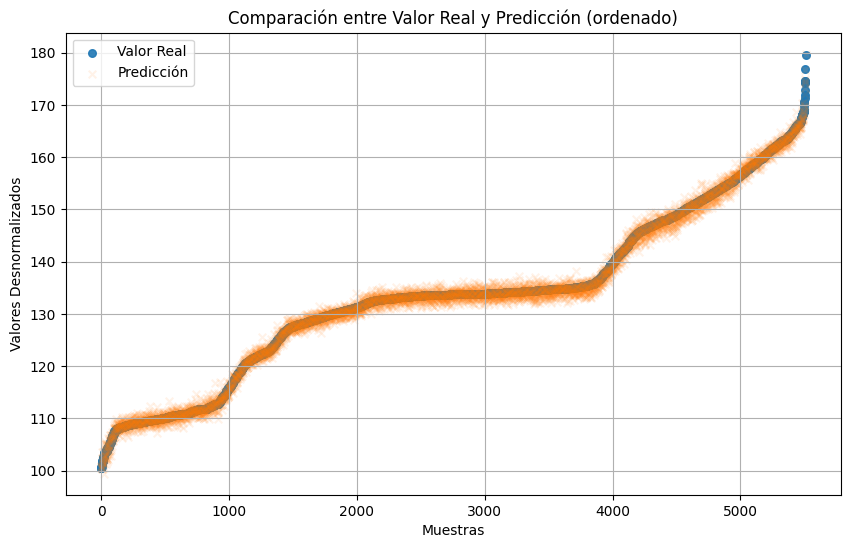

In [23]:
mejor_modelo = create_linear()
# CONFIGURAR MODELO Y ENTRENAMIENTO
lr = 0.1 # razon de aprendizaje
epochs = 20 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size=32
mejor_modelo.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'] )
historico = mejor_modelo.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_validation,y_validation),
shuffle=False, validation_freq=1)

# Obtenemos los errores de validación y entrenamiento del historial
historial_entrenamiento = historico.history['loss']
historial_validacion = historico.history['val_loss']

# Guardamos los errores de validación y entrenamiento en un archivo CSV
errores_df = pd.DataFrame({'Entrenamiento': historial_entrenamiento, 'Validacion': historial_validacion})
errores_df.to_csv('errores_Adaline_keras.csv', index=False)

# Guardamos el modelo completo
mejor_modelo.save('mejor_modelo_Adaline_keras.keras')

# Obtenemos el mejor modelo
mejor_modelo_PM = load_model('mejor_modelo_Adaline_keras.keras')

# Predecimos sobre los datos de test
prediccion_PM = mejor_modelo_PM.predict(X_test)
# Obtenemos el MSE de test
mse_PM = mean_squared_error(y_test, prediccion_PM)
print(f'Error de test: {mse_PM:.3e}')

# Desnormalizamos las predicciones y los valores deseados
prediccion_desnormalizada_PM = prediccion_PM * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min

mse_PM_desnormalizado = mean_squared_error(y_test_desnormalizada, prediccion_desnormalizada_PM)
print(f'Error de test desnormalizado: {mse_PM_desnormalizado}')

# Desnormalizamos las predicciones y los valores deseados
prediccion_desnormalizada_PM = prediccion_PM * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min

# Convertimos en lista
prediccion_desnormalizada_PM = prediccion_desnormalizada_PM.tolist()
y_test_desnormalizada = y_test_desnormalizada.tolist()

# Creamos un DataFrame con las predicciones y los valores reales
data_to_save_PM = pd.DataFrame({'Prediccion': np.array(prediccion_desnormalizada_PM).flatten(), 'Valor Real': y_test_desnormalizada})

# Ordenamos los valores reales de menor a mayor
sorted_data_PM = data_to_save_PM.sort_values(by='Valor Real')

sorted_data_PM.to_csv('predicciones_y_deseados_Adaline_keras.csv', index=False)

# Convertimos las columnas en listas de números
predicciones_PM = sorted_data_PM['Prediccion'].tolist()
valores_reales = sorted_data_PM['Valor Real'].tolist()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(range(len(valores_reales)), valores_reales, label='Valor Real', marker='o', s=30, alpha=0.9)
plt.scatter(range(len(predicciones_PM)), predicciones_PM, label='Predicción', marker='x', s=30, alpha=0.095)
plt.xlabel('Muestras')
plt.ylabel('Valores Desnormalizados')
plt.title('Comparación entre Valor Real y Predicción (ordenado)')
plt.legend()
plt.grid(True)

# Mostramos la gráfica
plt.show()



## 9. Perceptrón multicapa

### 9.2 Perceptrón multicapa con función de activación RELU

Definimos la función que crea el modelo.

In [25]:
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla , en este caso sera (21,)
# Definimos la función para crear el modelo
def create_PM_relu(num_hidden_neurons=50):
    #1 capa oculta con relu y 1 neurona de salida con sigmoide
    model = Sequential()
    model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

Construimos distintos modelos con diferentes hiperparámetros para evaluarlos con los datos de validación y poder escoger el mejor.

Epoch 1/10
804/804 [==============================] - 3s 3ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 4.8026e-04 - val_mse: 4.8026e-04
Epoch 2/10
804/804 [==============================] - 2s 3ms/step - loss: 4.7361e-04 - mse: 4.7361e-04 - val_loss: 3.9844e-04 - val_mse: 3.9844e-04
Epoch 3/10
804/804 [==============================] - 2s 2ms/step - loss: 4.1676e-04 - mse: 4.1676e-04 - val_loss: 3.7270e-04 - val_mse: 3.7270e-04
Epoch 4/10
804/804 [==============================] - 2s 2ms/step - loss: 3.9535e-04 - mse: 3.9535e-04 - val_loss: 3.6028e-04 - val_mse: 3.6028e-04
Epoch 5/10
804/804 [==============================] - 2s 2ms/step - loss: 3.8380e-04 - mse: 3.8380e-04 - val_loss: 3.5329e-04 - val_mse: 3.5329e-04
Epoch 6/10
804/804 [==============================] - 2s 2ms/step - loss: 3.7641e-04 - mse: 3.7641e-04 - val_loss: 3.4835e-04 - val_mse: 3.4835e-04
Epoch 7/10
804/804 [==============================] - 2s 2ms/step - loss: 3.7099e-04 - mse: 3.7099e-04 - val_loss: 3.448

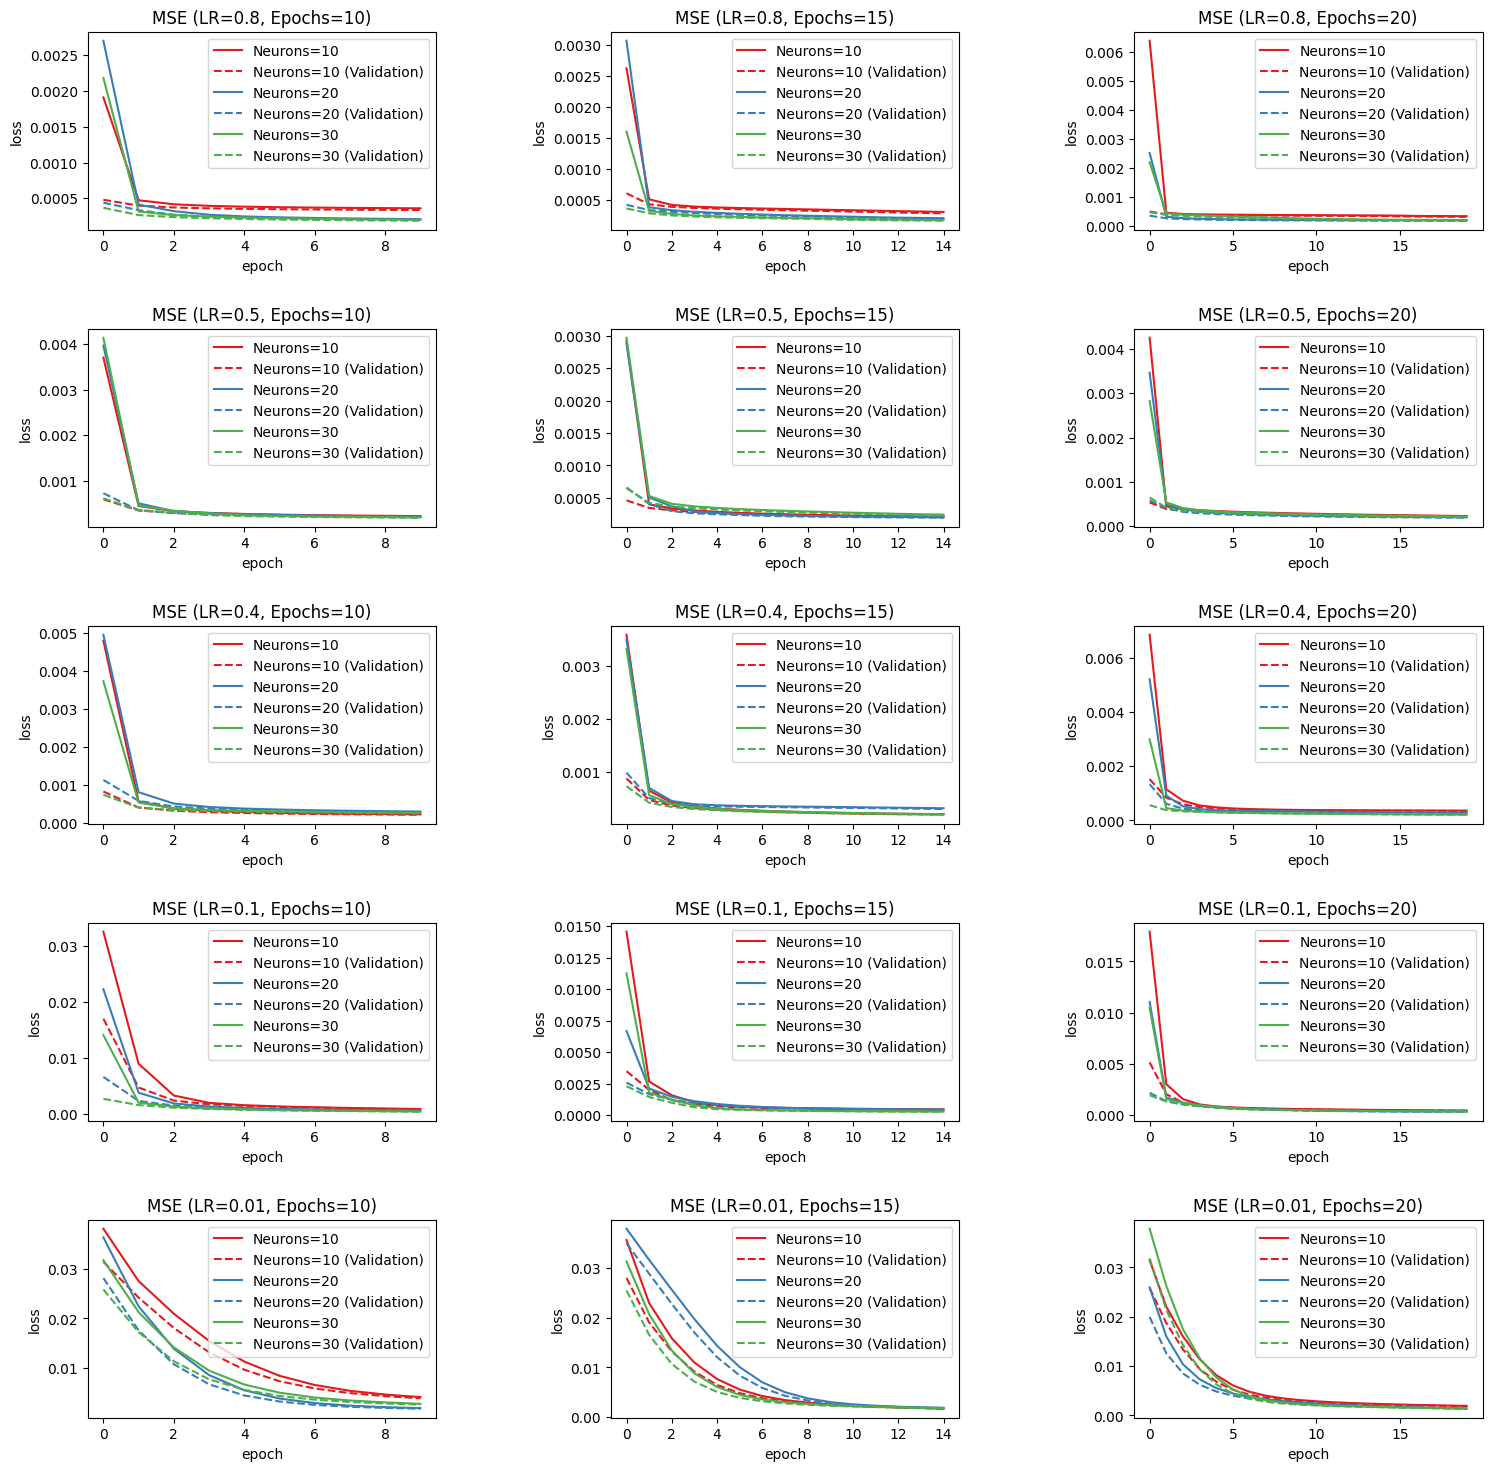

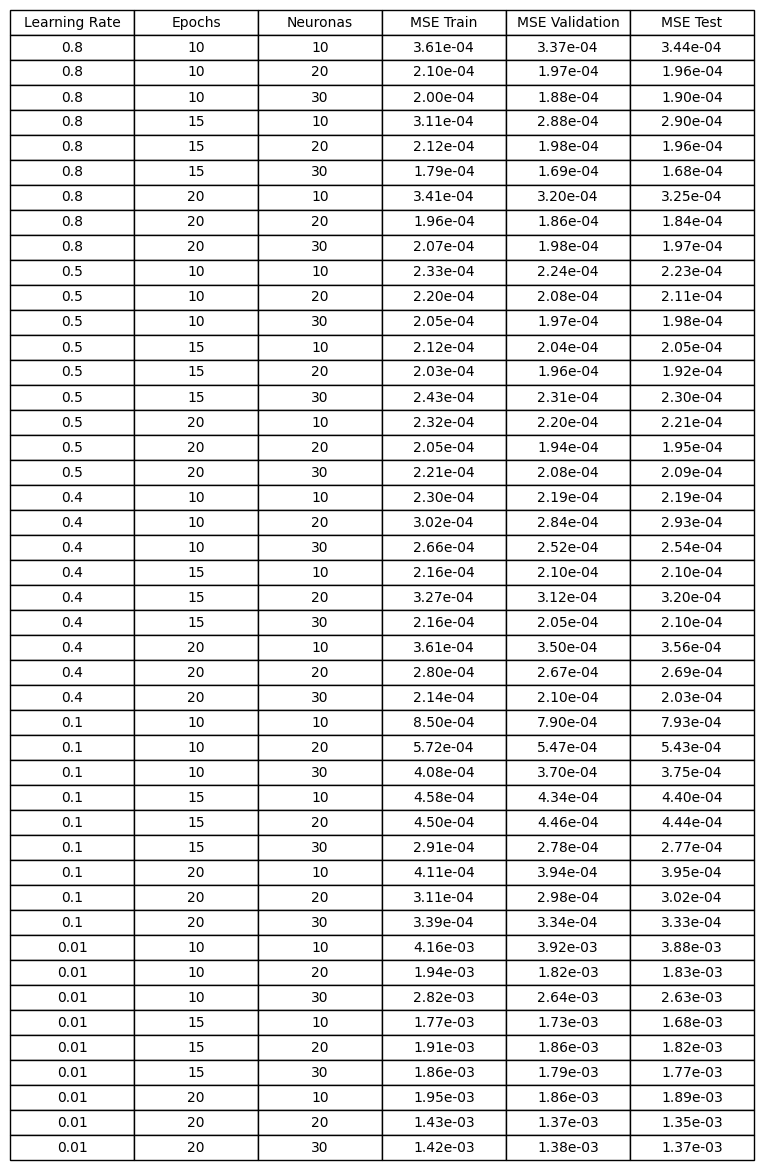

In [26]:
# Definimos una lista de valores para learning rates, número de neuronas ocultas y épocas
learning_rates = [0.8, 0.5, 0.4, 0.1, 0.01]
hidden_neurons = [10, 20, 30]
epochs_list = [10, 15, 20]
batch_size = 32

# Creamos un diccionario para almacenar los resultados
results = {
    'Learning Rate': [],
    'Epochs': [],
    'Neuronas': [],
    'MSE Train': [],
    'MSE Validation': [],
    'MSE Test' : []
}

# Configuramos el diseño de la figura
fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(18, 18))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Ajustamos el espacio vertical y horizontal

# Iteramos sobre las tasas de aprendizaje
for i, lr in enumerate(learning_rates):
    for k, epochs in enumerate(epochs_list):
        # Creamos una paleta de colores
        palette = sns.color_palette("Set1", len(hidden_neurons))

        # Configuramos la figura para esta tasa de aprendizaje y número de épocas
        ax = axes[i, k]

        for j, num_neurons in enumerate(hidden_neurons):
            model_relu = create_PM_relu(num_neurons)

            # CONFIGURAR MODELO Y ENTRENAMIENTO
            model_relu.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])
            start_time = time.time()
            historico = model_relu.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation, y_validation), shuffle=False, validation_freq=1)
            tiempo_total = time.time() - start_time
            print(f"Tiempo de entrenamiento para (lr = {lr}, epoch = {epochs}): {tiempo_total}s")
            # Obtenemos las predicciones
            prediccion_PM = model_relu.predict(X_test)
            # Obtenemos el MSE de test
            mse_test = mean_squared_error(y_test, prediccion_PM)
            print(f"MSE de test (lr = {lr}, epoch = {epochs}, num_neurons = {num_neurons}): {mse_test:.2e}")

            mse_train = historico.history['loss']
            mse_val = historico.history['val_loss']

            # Encontramos la época en la que el MSE de validación es el menor
            best_epoch = np.argmin(mse_val)

            # Obtenemos el valor mínimo del MSE de validación
            min_mse_val = np.min(mse_val)

            print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
            print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

            # Almacenamos los resultados en el diccionario
            results['Learning Rate'].append(lr)
            results['Epochs'].append(epochs)
            results['Neuronas'].append(num_neurons)
            results['MSE Train'].append(np.min(mse_train))
            results['MSE Validation'].append(np.min(mse_val))
            results['MSE Test'].append(mse_test)

             # Agregamos la gráfica a su subplot correspondiente
            ax.plot(historico.history['loss'], label=f'Neurons={num_neurons}', color=palette[j])
            ax.plot(historico.history['val_loss'], label=f'Neurons={num_neurons} (Validation)', linestyle='--', color=palette[j])
            ax.set_title(f'MSE (LR={lr}, Epochs={epochs})')
            ax.set_ylabel('loss')
            ax.set_xlabel('epoch')
            ax.legend()

# PRINTEAMOS LA TABLA
# Creamos un DataFrame a partir del diccionario de resultados
results_df = pd.DataFrame(results)

# Seleccionamos las dos últimas columnas y aplicamos formato en notación científica
results_df[['MSE Train', 'MSE Validation', 'MSE Test']] = results_df[['MSE Train', 'MSE Validation', 'MSE Test']].applymap(lambda x: f'{x:.2e}')

# Creamos una figura
fig, ax = plt.subplots(figsize=(8, 6))

# Creamos los datos de la tabla
data = [['Learning Rate', 'Epochs', 'Neuronas', 'MSE Train', 'MSE Validation', 'MSE Test']]
data += list(map(list, results_df.values))

# Creamos la tabla en la figura
tab = table(ax, cellText=data, loc='center', cellLoc='center', cellColours=[['#ffffff'] * 6] * (len(data)), colWidths=[0.2] * 6)
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(1, 1.5)

# Ocultamos ejes
ax.axis('off')

# Mostramos la figura
plt.show()


### 9.3 Perceptrón multicapa con función de activación sigmoide

Definimos la función para crear el modelo

In [ ]:
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla

def create_PM_sigmoid(num_hidden_neurons = 50):#se pone un valor por defecto a num_hidden_neurons, pero puede llamarse con otro valor
  #1 capa oculta y 1 neurona de salida con sigmoide
  model = Sequential() # generamos el modelo dandole una forma secuencial:
  model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='sigmoid')) # capa con x=num_hidden_neurons neuronas activadas con sigmoide
  model.add(Dense(1,activation='sigmoid')) # capa con x=1 neurona (solo una neurona de salida) activada con sigmoide
  return model

Construimos distintos modelos con diferentes hiperparámetros para evaluarlos con los datos de validación y poder escoger el mejor.

In [ ]:
# Definimos una lista de valores para learning rates, número de neuronas ocultas y épocas
learning_rates = [0.8, 0.5, 0.4, 0.1, 0.01]
hidden_neurons = [10, 20, 30]
epochs_list = [10, 15, 20]
batch_size = 32

# Creamos un diccionario para almacenar los resultados
results = {
    'Learning Rate': [],
    'Epochs': [],
    'Neuronas': [],
    'MSE Train': [],
    'MSE Validation': [],
    'MSE Test' : []
}

# Configuramos el diseño de la figura
fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(18, 18))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Ajustamos el espacio vertical y horizontal

# Iteramos sobre las tasas de aprendizaje
for i, lr in enumerate(learning_rates):
    for k, epochs in enumerate(epochs_list):
        # Creamos una paleta de colores
        palette = sns.color_palette("Set1", len(hidden_neurons))

        # Configuramos la figura para esta tasa de aprendizaje y número de épocas
        ax = axes[i, k]

        for j, num_neurons in enumerate(hidden_neurons):
            model_sigmoid = create_PM_sigmoid(num_neurons)

            # CONFIGURAR MODELO Y ENTRENAMIENTO
            model_sigmoid.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])
            start_time = time.time()
            historico = model_sigmoid.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation, y_validation), shuffle=False, validation_freq=1)
            tiempo_total = time.time() - start_time
            print(f"Tiempo de entrenamiento para (lr = {lr}, epoch = {epochs}): {tiempo_total}s")
            # Obtenemos las predicciones
            prediccion_PM = model_sigmoid.predict(X_test)
            # Obtenemos el MSE de test
            mse_test = mean_squared_error(y_test, prediccion_PM)
            print(f"MSE de test (lr = {lr}, epoch = {epochs}, num_neurons = {num_neurons}): {mse_test:.2e} \n")

            mse_train = historico.history['loss']
            mse_val = historico.history['val_loss']

            # Almacenamos los resultados en el diccionario
            results['Learning Rate'].append(lr)
            results['Epochs'].append(epochs)
            results['Neuronas'].append(num_neurons)
            results['MSE Train'].append(np.min(mse_train))
            results['MSE Validation'].append(np.min(mse_val))
            results['MSE Test'].append(mse_test)

             # Agregamos la gráfica a su subplot correspondiente
            ax.plot(historico.history['loss'], label=f'Neurons={num_neurons}', color=palette[j])
            ax.plot(historico.history['val_loss'], label=f'Neurons={num_neurons} (Validation)', linestyle='--', color=palette[j])
            ax.set_title(f'MSE (LR={lr}, Epochs={epochs})')
            ax.set_ylabel('loss')
            ax.set_xlabel('epoch')
            ax.legend()

# PRINTEAMOS LA TABLA
# Creamos un DataFrame a partir del diccionario de resultados
results_df = pd.DataFrame(results)

# Seleccionamos las dos últimas columnas y aplicamos formato en notación científica
results_df[['MSE Train', 'MSE Validation', 'MSE Test']] = results_df[['MSE Train', 'MSE Validation', 'MSE Test']].applymap(lambda x: f'{x:.2e}')

# Creamos una figura
fig, ax = plt.subplots(figsize=(8, 6))

# Creamos los datos de la tabla
data = [['Learning Rate', 'Epochs', 'Neuronas', 'MSE Train', 'MSE Validation', 'MSE Test']]
data += list(map(list, results_df.values))

# Creamos la tabla en la figura
tab = table(ax, cellText=data, loc='center', cellLoc='center', cellColours=[['#ffffff'] * 6] * (len(data)), colWidths=[0.2] * 6)
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(1, 1.5)

# Ocultamos ejes
ax.axis('off')

# Mostramos la figura
plt.show()


### 9.4 Elección y guardado del mejor modelo
Observando los resultados, el mejor modelo es el que se construye utilizando la función de activación RELU con un learning_rate de 0.5, 20 épocas y 20 neuronas ocultas ya que es el que obtiene un MSE de validación más bajo (1.91 e-04). Por tanto, creamos y entrenamos de nuevo un modelo con estos hiperparámetros y lo guardamos.

También guardamos su error de entrenamiento y de validación.

In [ ]:
mejor_modelo = create_PM_relu(30)
# CONFIGURAR MODELO Y ENTRENAMIENTO
lr = 0.4 # razon de aprendizaje
epochs = 20 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size=32
mejor_modelo.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'] )
historico = mejor_modelo.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_validation,y_validation),
shuffle=False, validation_freq=1)

# Obtenemos los errores de validación y entrenamiento del historial
historial_entrenamiento = historico.history['loss']
historial_validacion = historico.history['val_loss']

# Guardamos los errores de validación y entrenamiento en un archivo CSV
errores_df = pd.DataFrame({'Entrenamiento': historial_entrenamiento, 'Validacion': historial_validacion})
errores_df.to_csv('errores_PM.csv', index=False)

# Guardamos el modelo completo
mejor_modelo.save('mejor_modelo_PM.keras')

### 9.6 Error de test y predicciones

Obtenemos el mejor modelo que hemos guardado anteriormente

In [ ]:
# Obtenemos el mejor modelo
mejor_modelo_PM = load_model('mejor_modelo_PM.keras')

Evaluamos el mejor modelo con los datos de test

In [ ]:
# Predecimos sobre los datos de test
prediccion_PM = mejor_modelo_PM.predict(X_test)
# Obtenemos el MSE de test
mse_PM = mean_squared_error(y_test, prediccion_PM)
print(f'Error de test: {mse_PM:.3e}')

# Desnormalizamos las predicciones y los valores deseados
prediccion_desnormalizada_PM = prediccion_PM * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min

mse_PM_desnormalizado = mean_squared_error(y_test_desnormalizada, prediccion_desnormalizada_PM)
print(f'Error de test desnormalizado: {mse_PM_desnormalizado}')

Desnormalizamos las predicciones y las comparamos con los valores deseados.

In [ ]:
# Desnormalizamos las predicciones y los valores deseados
prediccion_desnormalizada_PM = prediccion_PM * (y_max - y_min) + y_min
y_test_desnormalizada = y_test * (y_max - y_min) + y_min

# Convertimos en lista
prediccion_desnormalizada_PM = prediccion_desnormalizada_PM.tolist()
y_test_desnormalizada = y_test_desnormalizada.tolist()

# Creamos un DataFrame con las predicciones y los valores reales
data_to_save_PM = pd.DataFrame({'Prediccion': np.array(prediccion_desnormalizada_PM).flatten(), 'Valor Real': y_test_desnormalizada})

# Ordenamos los valores reales de menor a mayor
sorted_data_PM = data_to_save_PM.sort_values(by='Valor Real')

sorted_data_PM.to_csv('predicciones_y_deseados_PM.csv', index=False)

# Convertimos las columnas en listas de números
predicciones_PM = sorted_data_PM['Prediccion'].tolist()
valores_reales = sorted_data_PM['Valor Real'].tolist()

# Creamos la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(range(len(valores_reales)), valores_reales, label='Valor Real', marker='o', s=30, alpha=0.9)
plt.scatter(range(len(predicciones_PM)), predicciones_PM, label='Predicción', marker='x', s=30, alpha=0.095)
plt.xlabel('Muestras')
plt.ylabel('Valores Desnormalizados')
plt.title('Comparación entre Valor Real y Predicción (ordenado)')
plt.legend()
plt.grid(True)

# Mostramos la gráfica
plt.show()